<a href="https://colab.research.google.com/github/NathanUsw/BankFraud/blob/main/BankFraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
from imblearn.over_sampling import SMOTE
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, Callback
import gc
from tensorflow.keras import backend as K

In [2]:
class ClearMemoryCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()          # Collect garbage
        K.clear_session()     # Clear the Keras session to free memory

In [3]:
# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/ML_Projects/Merged_Base2Compatible.csv')

# Strip any leading/trailing whitespace from the column names
data.columns = data.columns.str.strip()

# Print the column names to verify
print("Column Names:", data.columns)

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# List of categorical columns to encode
categorical_cols = ['payment_type', 'source', 'device_os', 'employment_status', 'housing_status']

# Apply LabelEncoder to each categorical column, if it exists
for col in categorical_cols:
    if col in data.columns:
        data[col] = label_encoder.fit_transform(data[col])
    else:
        print(f"Warning: Column '{col}' not found in the dataset. Skipping this column.")

# Apply LabelEncoder to each categorical column
for col in categorical_cols:
    data[col] = label_encoder.fit_transform(data[col])

# Fill missing values (if any)
data = data.fillna(data.mean())

# Define the feature set (X) and the target (y)
X = data.drop(columns=['fraud_bool'])  # Features
y = data['fraud_bool']  # Target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Build the autoencoder model
input_dim = X_train_res.shape[1]

autoencoder = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(input_dim,)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(input_dim, activation='linear')
])

# Compile the autoencoder model
autoencoder.compile(optimizer='adam', loss='mse')

Column Names: Index(['fraud_bool', 'income', 'name_email_similarity',
       'prev_address_months_count', 'current_address_months_count',
       'customer_age', 'days_since_request', 'intended_balcon_amount',
       'payment_type', 'zip_count_4w', 'velocity_6h', 'velocity_24h',
       'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'employment_status',
       'credit_risk_score', 'email_is_free', 'housing_status',
       'phone_home_valid', 'phone_mobile_valid', 'bank_months_count',
       'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'source',
       'session_length_in_minutes', 'device_os', 'keep_alive_session',
       'device_distinct_emails_8w', 'device_fraud_count', 'month'],
      dtype='object')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
158244/158244 ━━━━━━━━━━━━━━━━━━━━ 276s 2ms/step - loss: 21649.9336 - val_loss: 355892.6250
Epoch 2/100
158244/158244 ━━━━━━━━━━━━━━━━━━━━ 268s 2ms/step - loss: 3255.6946 - val_loss: 357906.2500
Epoch 3/100
158244/158244 ━━━━━━━━━━━━━━━━━━━━ 269s 2ms/step - loss: 2652.0063 - val_loss: 360844.2188
Epoch 4/100
158244/158244 ━━━━━━━━━━━━━━━━━━━━ 269s 2ms/step - loss: 2234.0168 - val_loss: 365043.2500
Epoch 5/100
158244/158244 ━━━━━━━━━━━━━━━━━━━━ 270s 2ms/step - loss: 2026.3944 - val_loss: 362157.4062
Epoch 6/100
158244/158244 ━━━━━━━━━━━━━━━━━━━━ 271s 2ms/step - loss: 1762.0262 - val_loss: 356876.3750
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 27s 1ms/step


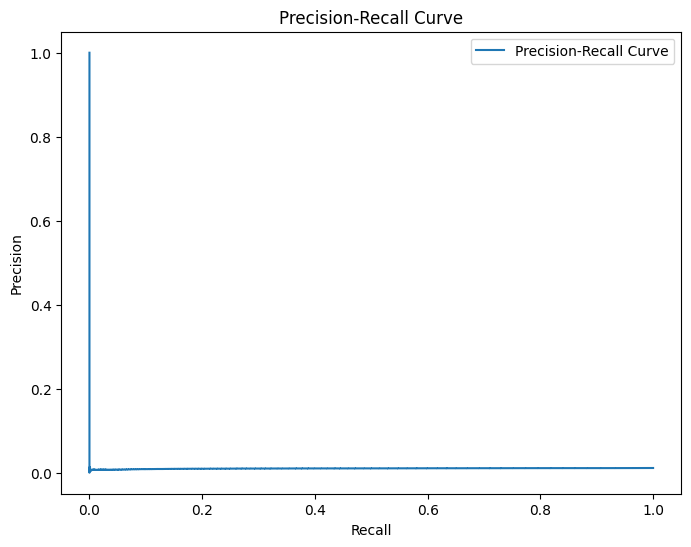

Threshold for Fraud Detection: 840686.4050205598
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.95      0.97    791003
           1       0.01      0.03      0.01      8997

    accuracy                           0.94    800000
   macro avg       0.50      0.49      0.49    800000
weighted avg       0.98      0.94      0.96    800000



In [4]:
# Train the autoencoder on the oversampled data
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
clear_memory = ClearMemoryCallback()

history = autoencoder.fit(X_train_res, X_train_res,
                          epochs=100,
                          batch_size=32,
                          validation_split=0.2,
                          callbacks=[early_stopping, clear_memory],
                          verbose=1)

# Reconstruction errors on the test set
X_test_pred = autoencoder.predict(X_test)
reconstruction_error = np.mean(np.square(X_test - X_test_pred), axis=1)

# ROC-AUC and Precision-Recall Curve for threshold tuning
precision, recall, thresholds_pr = precision_recall_curve(y_test, reconstruction_error)
roc_auc = roc_auc_score(y_test, reconstruction_error)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Set threshold using a percentile or a tuned threshold using PR curve
threshold = np.percentile(reconstruction_error, 95)
# Alternatively, experiment with a threshold from the PR curve:
# threshold = thresholds_pr[np.argmax(precision * recall)]

# Predict fraud if reconstruction error is above threshold
y_pred = (reconstruction_error > threshold).astype(int)

# Evaluate the model
print(f'Threshold for Fraud Detection: {threshold}')
print("Classification Report:\n", classification_report(y_test, y_pred))


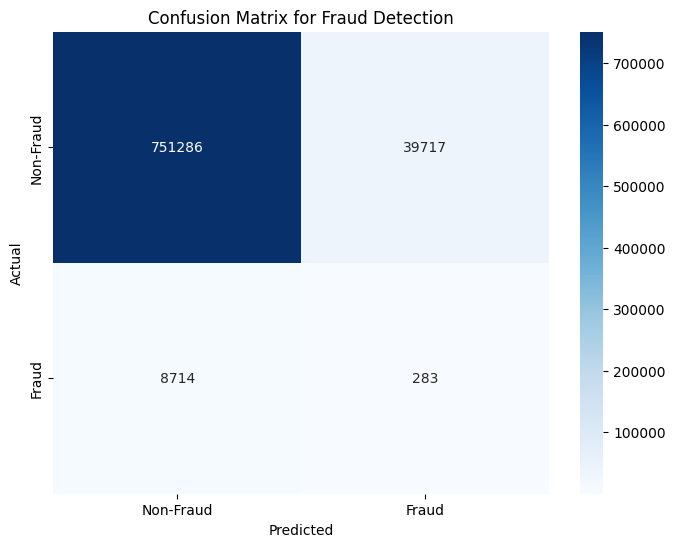

<ipython-input-5-73a8ad1f4966>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette='coolwarm')
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-lik

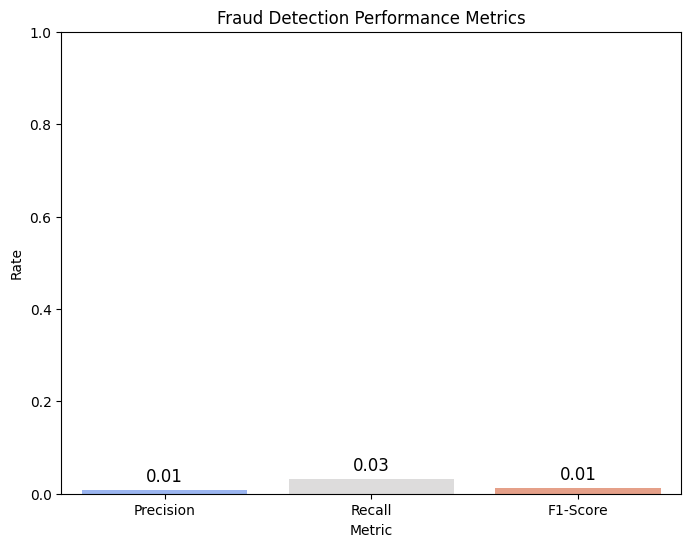

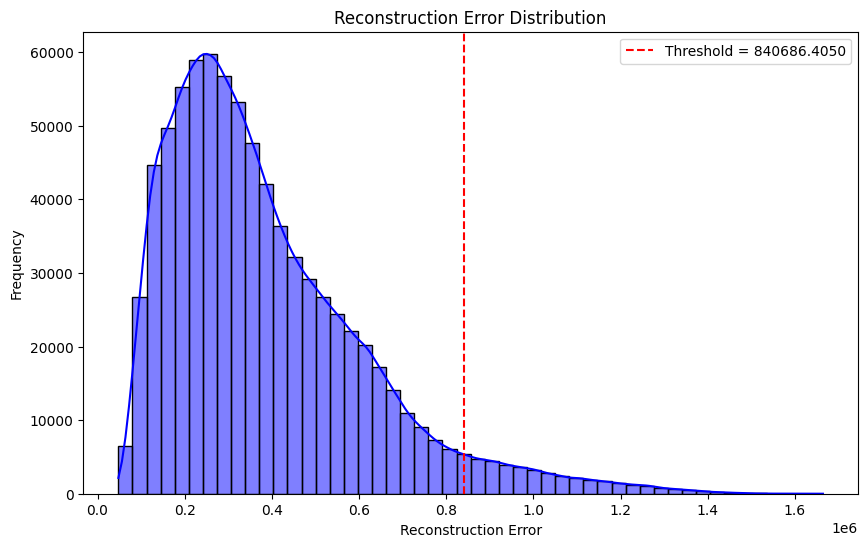

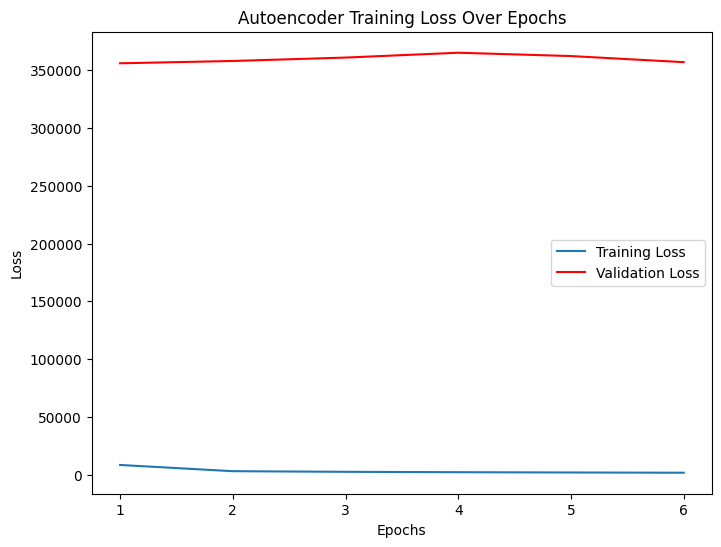

In [5]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix for Fraud Detection')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate performance metrics
true_positives = conf_matrix[1, 1]
false_positives = conf_matrix[0, 1]
true_negatives = conf_matrix[0, 0]
false_negatives = conf_matrix[1, 0]

# Fraud detection rate (Precision, Recall, and F1-score)
precision = true_positives / (true_positives + false_positives + 1e-10)
recall = true_positives / (true_positives + false_negatives + 1e-10)
f1_score = 2 * (precision * recall) / (precision + recall + 1e-10)

# Plot Fraud Detection Rates (Precision, Recall, F1)
metrics = ['Precision', 'Recall', 'F1-Score']
values = [precision, recall, f1_score]

plt.figure(figsize=(8, 6))
sns.barplot(x=metrics, y=values, palette='coolwarm')
plt.title('Fraud Detection Performance Metrics')
plt.ylim(0, 1)
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', color='black', fontsize=12)
plt.ylabel('Rate')
plt.xlabel('Metric')
plt.show()

# Plot reconstruction error distribution
plt.figure(figsize=(10, 6))
sns.histplot(reconstruction_error, bins=50, kde=True, color='blue')
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold:.4f}')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Plot validation loss over epochs
plt.figure(figsize=(8, 6))
sns.lineplot(x=range(1, len(history.history['loss']) + 1), y=history.history['loss'], label='Training Loss')
sns.lineplot(x=range(1, len(history.history['val_loss']) + 1), y=history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Autoencoder Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()